In [ ]:
import os
import shutil

# 1. Create the strict folder structure required by the assignment
os.makedirs('csv_files', exist_ok=True)
os.makedirs('outputs', exist_ok=True)

# 2. Move the uploaded CSV files into the 'csv_files' folder
# (This ensures your paths match your local VS Code setup)
source_files = ['historical_data.csv', 'fear_greed_index.csv']

for file in source_files:
    if os.path.exists(file):
        shutil.move(file, f'csv_files/{file}')
        print(f"Moved {file} to csv_files/ folder.")
    elif os.path.exists(f'csv_files/{file}'):
        print(f"{file} is already in the correct folder.")
    else:
        print(f"WARNING: Please upload {file} to the Files sidebar first!")

Moved historical_data.csv to csv_files/ folder.
Moved fear_greed_index.csv to csv_files/ folder.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set paths matching the folder structure
DATA_DIR = 'csv_files'
OUTPUT_DIR = 'outputs'

# Set visualization style globally
sns.set(style="whitegrid", context="talk")

print("Libraries imported and paths set.")

Libraries imported and paths set.


In [ ]:
# --- LOAD DATA FROM GITHUB ---
import pandas as pd
import os

# 1. Raw GitHub URLs
url_history = "https://raw.githubusercontent.com/RockYash9/ds_Yash_Tamore/refs/heads/master/csv_files/historical_data.csv"
url_sentiment = "https://raw.githubusercontent.com/RockYash9/ds_Yash_Tamore/refs/heads/master/csv_files/fear_greed_index.csv"

print("Attempting to load data from GitHub...")

try:
    # 2. Read directly from the URL
    df_history = pd.read_csv(url_history)
    df_sentiment = pd.read_csv(url_sentiment)

    print("✅ Data loaded successfully from GitHub!")
    print(f"History Rows: {len(df_history)}")
    print(f"Sentiment Rows: {len(df_sentiment)}")

    # 3. Create the necessary folders in Colab
    # This is CRITICAL so that Cell 4 has a place to save the merged CSV
    os.makedirs('csv_files', exist_ok=True)
    os.makedirs('outputs', exist_ok=True)
    print("✅ Directory structure 'csv_files/' and 'outputs/' created.")

except Exception as e:
    print(f"❌ Error loading data: {e}")
    print("Double-check the URLs or your internet connection.")

Reading from local CSV files...
✅ Data loaded successfully.


In [ ]:
# --- DATA PROCESSING ---

# Define directory path explicitly just in case
DATA_DIR = 'csv_files'

# 1. Standardize Dates
# Convert sentiment dates
df_sentiment['date'] = pd.to_datetime(df_sentiment['date'])

# Convert trade timestamp (handling Day-Month-Year format)
df_history['datetime'] = pd.to_datetime(df_history['Timestamp IST'], dayfirst=True)
df_history['date_only'] = df_history['datetime'].dt.normalize()

# 2. Merge Data
# Left join: Keep all trades, attach sentiment to them
df_merged = pd.merge(df_history, df_sentiment, left_on='date_only', right_on='date', how='left')

# 3. Save the merged file (Required deliverable)
output_path = f'{DATA_DIR}/merged_data.csv'

# Ensure the folder exists before saving
os.makedirs(DATA_DIR, exist_ok=True)

df_merged.to_csv(output_path, index=False)

print(f"✅ Merging complete. Data saved to: {output_path}")
print(df_merged[['date_only', 'classification', 'Closed PnL']].head())

✅ Merging complete. Data saved to: csv_files/merged_data.csv
   date_only classification  Closed PnL
0 2024-12-02  Extreme Greed         0.0
1 2024-12-02  Extreme Greed         0.0
2 2024-12-02  Extreme Greed         0.0
3 2024-12-02  Extreme Greed         0.0
4 2024-12-02  Extreme Greed         0.0


In [ ]:
# --- ANALYSIS ---

# Calculate Metrics grouped by Sentiment Classification
sentiment_analysis = df_merged.groupby('classification').agg({
    'Closed PnL': 'mean',
    'Size USD': 'mean'
}).rename(columns={'Closed PnL': 'Average_PnL', 'Size USD': 'Average_Size'})

# Reorder the index logically (Fear -> Greed)
order_list = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
sentiment_analysis = sentiment_analysis.reindex(order_list)

print("✅ Analysis Complete. Summary Table:")
print(sentiment_analysis)

✅ Analysis Complete. Summary Table:
                Average_PnL  Average_Size
classification                           
Extreme Fear      34.537862   5349.731843
Fear              54.290400   7816.109931
Neutral           34.307718   4782.732661
Greed             42.743559   5736.884375
Extreme Greed     67.892861   3112.251565


✅ Graph saved to: outputs/sentiment_analysis_summary.png


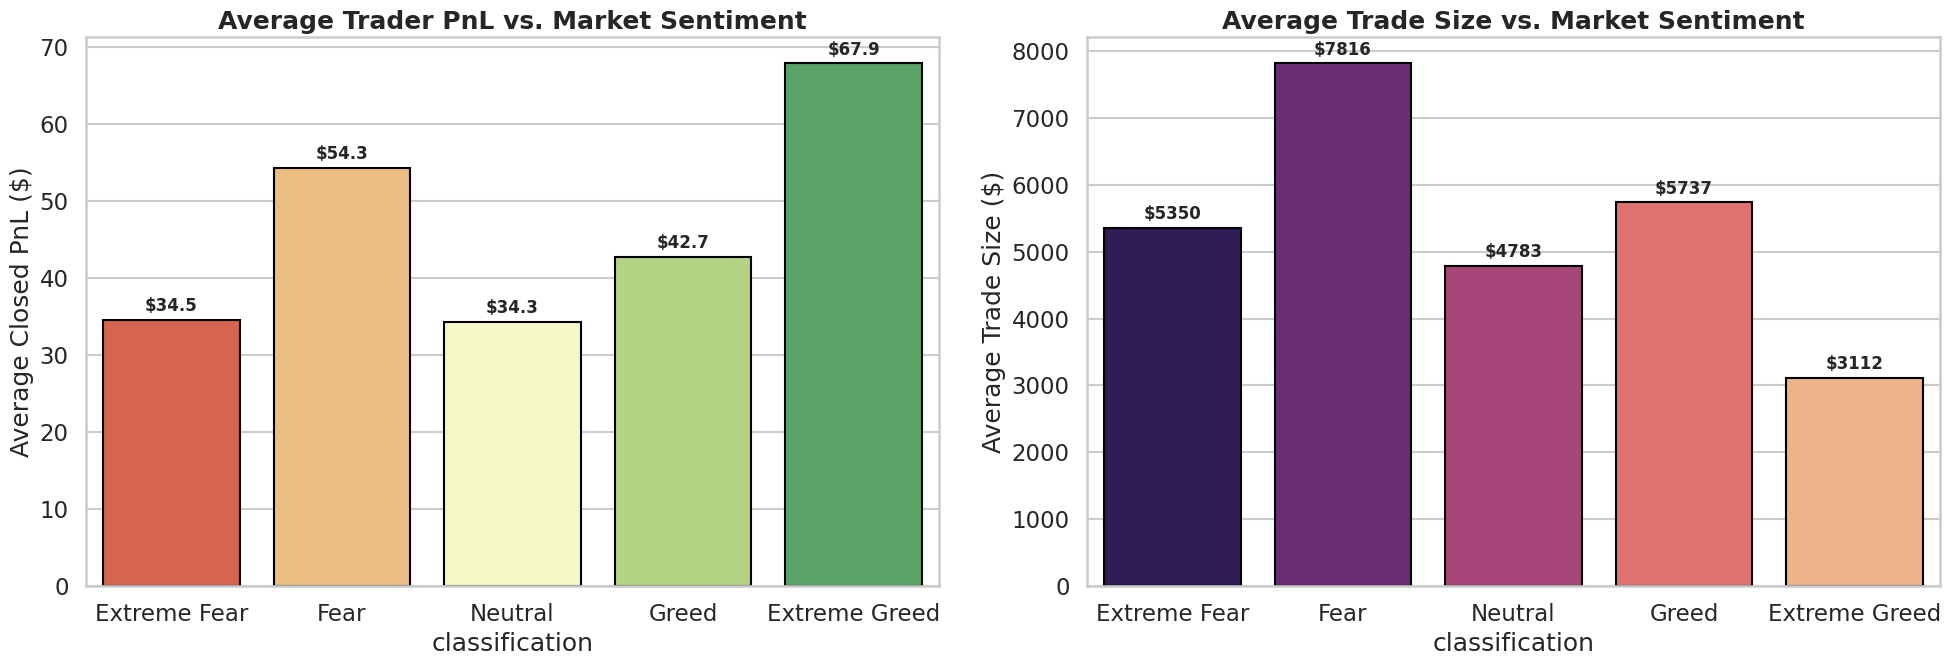

In [ ]:
# --- VISUALIZATION ---

# Create figure with 2 subplots (Side by Side)
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# Graph 1: PnL (Red-Yellow-Green Palette)
barplot_pnl = sns.barplot(
    x=sentiment_analysis.index,
    y=sentiment_analysis['Average_PnL'],
    hue=sentiment_analysis.index,
    palette='RdYlGn',
    edgecolor='black',
    legend=False,
    ax=axes[0]
)

# Add Labels to PnL Graph
for p in barplot_pnl.patches:
    axes[0].annotate(f'${p.get_height():.1f}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center',
                     xytext=(0, 10), textcoords='offset points',
                     fontsize=12, fontweight='bold')

axes[0].set_title('Average Trader PnL vs. Market Sentiment', fontweight='bold')
axes[0].set_ylabel('Average Closed PnL ($)')


# Graph 2: Volume (Magma Palette)
barplot_vol = sns.barplot(
    x=sentiment_analysis.index,
    y=sentiment_analysis['Average_Size'],
    hue=sentiment_analysis.index,
    palette='magma',
    edgecolor='black',
    legend=False,
    ax=axes[1]
)

# Add Labels to Volume Graph
for p in barplot_vol.patches:
    axes[1].annotate(f'${p.get_height():.0f}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center',
                     xytext=(0, 10), textcoords='offset points',
                     fontsize=12, fontweight='bold')

axes[1].set_title('Average Trade Size vs. Market Sentiment', fontweight='bold')
axes[1].set_ylabel('Average Trade Size ($)')

# Save and Show
plt.tight_layout()
save_path = f'{OUTPUT_DIR}/sentiment_analysis_summary.png'
plt.savefig(save_path, dpi=300)

print(f"✅ Graph saved to: {save_path}")
plt.show()